In [2]:
#from src.utils.camera_utils import *
from src.utils.gym_utils import *
from src.utils.input_utils import *

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
Importing module 'gym_38' (/SPACE/hair02/storm/python/isaacgym/_bindings/linux-x86_64/gym_38.so)
Setting GYM_USD_PLUG_INFO_PATH to /SPACE/hair02/storm/python/isaacgym/_bindings/linux-x86_64/usd/plugInfo.json
PyTorch version 1.10.1+cu102
Device count 2
/SPACE/hair02/storm/python/isaacgym/_bindings/src/gymtorch
Using /SPACE/hair02/.cache/torch_extensions/py38_cu102 as PyTorch extensions root...
Emitting ninja build file /SPACE/hair02/.cache/torch_extensions/py38_cu102/gymtorch/build.ninja...
Building extension module gymtorch...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)
ninja: no work to do.
Loading extension module gymtorch...


/SPACE/hair02/.local/lib/python3.8/site-packages/quaternion/numba_wrapper.py:23: UserWarning: 

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Could not import from numba, which means that some
parts of this code may run MUCH more slowly.  You
may wish to install numba.
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

  warnings.warn(warning_text)


In [3]:
import h5py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
import cv2

In [4]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
import transforms as T
import os
import numpy as np
import torch
from PIL import Image
import utils
from engine import train_one_epoch, evaluate
import utils
from PIL import Image as im
import torch
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [5]:
backbone = torchvision.models.mobilenet_v2(pretrained=True).features

In [6]:
backbone.out_channels = 1280

In [7]:
anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),aspect_ratios=((0.5, 1.0, 2.0),))

In [8]:
roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'],output_size=7,sampling_ratio=2)

In [9]:
model = FasterRCNN(backbone,num_classes=2,rpn_anchor_generator=anchor_generator,box_roi_pool=roi_pooler)

In [10]:
def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

In [11]:
def get_transform(train):
    transforms = []
    transforms.append(T.PILToTensor())
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [12]:
class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        # load images and masks
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        mask = Image.open(mask_path)
        # convert the PIL Image into a numpy array
        mask = np.array(mask)
        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]

        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None]

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        # convert everything into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes.type(torch.float32)
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img.type(torch.float32), target

    def __len__(self):
        return len(self.imgs)

In [13]:
def main():
    # train on the GPU or on the CPU, if a GPU is not available
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

    # our dataset has two classes only - background and person
    num_classes = 2
    # use our dataset and defined transformations
    dataset = PennFudanDataset('PennFudanPed', get_transform(train=True))
    dataset_test = PennFudanDataset('PennFudanPed', get_transform(train=False))

    # split the dataset in train and test set
    indices = torch.randperm(len(dataset)).tolist()
    dataset = torch.utils.data.Subset(dataset, indices[:-50])
    dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

    # define training and validation data loaders
    data_loader = torch.utils.data.DataLoader(
        dataset, batch_size=2, shuffle=True, num_workers=4,
        collate_fn=utils.collate_fn)

    data_loader_test = torch.utils.data.DataLoader(
        dataset_test, batch_size=1, shuffle=False, num_workers=4,
        collate_fn=utils.collate_fn)

    # get the model using our helper function
    model = get_model_instance_segmentation(num_classes)

    # move model to the right device
    model.to(device)

    # construct an optimizer
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=0.005,
                                momentum=0.9, weight_decay=0.0005)
    # and a learning rate scheduler
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                   step_size=3,
                                                   gamma=0.1)

    # let's train it for 10 epochs
    num_epochs = 10

    for epoch in range(num_epochs):
        # train for one epoch, printing every 10 iterations
        #train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
        # update the learning rate
        #lr_scheduler.step()
        # evaluate on the test dataset
        evaluate(model, data_loader_test, device=device)

    print("That's it!")

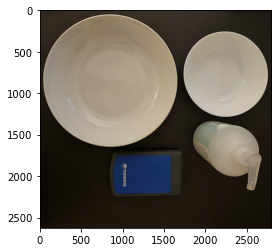

In [14]:
image = Image.open('data/concept_shapenet/12.png')
  
transform = transforms.Compose([transforms.PILToTensor()])
  
img_tensor = transform(image)
  
plt.imshow(img_tensor.cpu().permute(1,2,0))

In [15]:
img_tensor.shape
#img=img_tensor

torch.Size([4, 2624, 2791])

In [16]:
img = img_tensor[:3,:,:]
img.shape

torch.Size([3, 2624, 2791])

In [17]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
num_classes = 100
#in_features = model.roi_heads.box_predictor.cls_score.in_features
#model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

torch.Size([3, 2624, 2791])


WARNING - 2022-12-01 23:43:45,709 - warnings - /SPACE/hair02/.local/lib/python3.8/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]



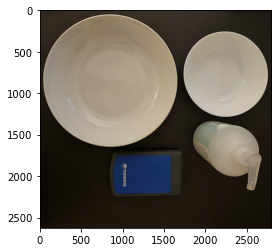

In [18]:
model.eval()
#plt.imshow(img_tensor.cpu().permute(1,2,0))
plt.imshow(img.cpu().permute(1,2,0))
print(img.shape)
#print(img_tensor.shape)
#img = img_tensor/255
img = img/255
out = model.forward([img])

In [19]:
out

[{'boxes': tensor([[   0.0000,    0.0000, 2791.0001, 2512.7363],
          [ 851.8681, 1661.8625, 1728.2560, 2235.1737],
          [  26.7670,   54.0365, 1669.9295, 1630.6249],
          [1847.8726, 1334.2103, 2633.9103, 2021.0438],
          [1838.6379, 1316.7391, 2617.9805, 1979.6687],
          [1728.7269,  238.6084, 2755.9415, 1291.2971],
          [1825.5802, 1326.7670, 2620.9552, 2031.3947],
          [ 882.1662, 1694.9384, 1706.1676, 2211.3919],
          [  59.6763,   34.2604, 1727.0275, 1614.2591],
          [1705.8519,  251.3484, 2722.3997, 1286.6052],
          [ 873.1502, 1696.1647, 1711.4289, 2212.3975],
          [1851.7500, 1317.4145, 2675.9290, 2097.2481],
          [  32.8977,    0.0000, 1669.5138, 1633.7992],
          [ 829.0838, 1672.3565, 1717.7248, 2224.4861],
          [1847.6964, 1352.9456, 2657.7255, 2033.7030],
          [  13.6725,    4.6922, 1708.2054, 1668.6503],
          [1864.8777, 1332.1230, 2607.8814, 2009.1229],
          [1689.4630,  248.6976, 2737.8

(0.0, 2791.0)

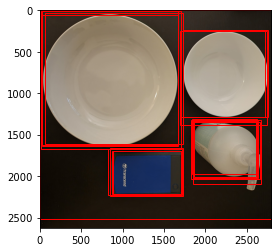

In [20]:
#plt.imshow(img_tensor.cpu().permute(1,2,0))
fig, ax = plt.subplots()
for i, sq in enumerate(out[-1]["boxes"]):
    #if out[-1]["labels"][i] == 49:# and out[-1]["scores"][i] > 0.3:
    sq = sq.detach()
    rectangle = plt.Rectangle((sq[0], sq[1]), sq[2]-sq[0], sq[3]-sq[1], fill=False, color="red")
    ax.add_patch(rectangle)
plt.axis("scaled")
ax.imshow(img_tensor.cpu().permute(1,2,0))
#plt.ylim(250,0)
#plt.xlim(0,250)
plt.ylim(img.shape[1],0)
plt.xlim(0,img.shape[2])
#0,1,2,16

## NMS

In [21]:
#box = []
#box.append(box1)
#box.append(box2)
#box = np.array(box)

box = out[-1]["boxes"].detach().numpy()
score = out[-1]["scores"].detach().numpy()

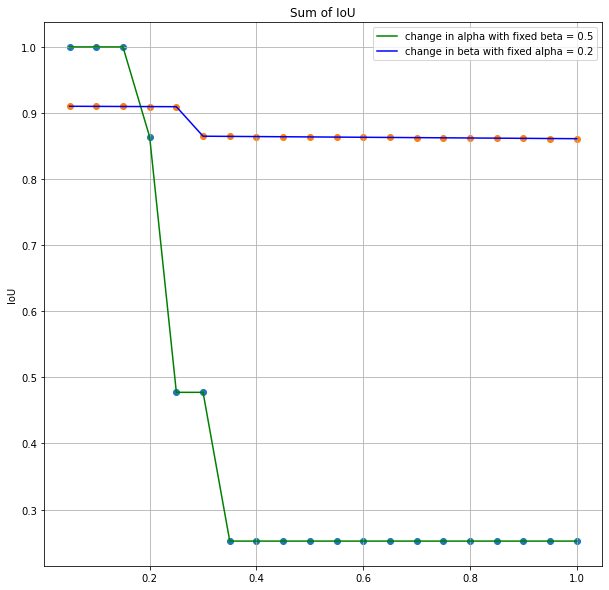

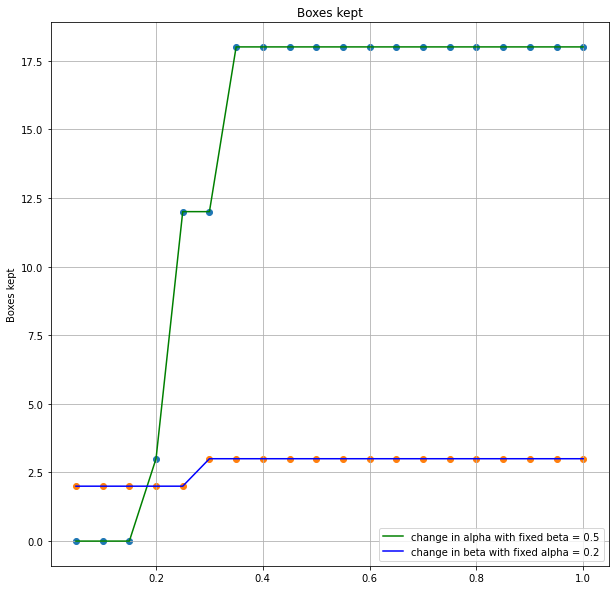

In [30]:
from sklearn.preprocessing import normalize, MinMaxScaler

def nms_pytorch(box,score, t_iou):
    box = torch.tensor(box)
    print()
    score = torch.tensor(score)
    x1 = box[:,0]
    y1 = box[:,1]
    x2 = box[:,2]
    y2 = box[:,3]
    #print(box,'x1',x1,'y1',y1,'x2',x2,'y2',y2)

    areas = (x2 - x1) * (y2 - y1)
    order = score.argsort()
    keep = []
    iou = []
    while len(order) > 0:
        idx = order[-1]
        keep.append(box[idx])
        order = order[:-1]
        xx1 = torch.index_select(x1,dim = 0, index = order)
        #print('xx1',xx1)
        xx2 = torch.index_select(x2,dim = 0, index = order)
        #print('xx2',xx2)
        yy1 = torch.index_select(y1,dim = 0, index = order)
        #print('yy1',yy1)
        yy2 = torch.index_select(y2,dim = 0, index = order)
        #print('yy2',yy2)
        xx1 = torch.max(xx1, x1[idx])
        #print('xx1max',xx1)
        yy1 = torch.max(yy1, y1[idx])
        xx2 = torch.min(xx2, x2[idx])
        yy2 = torch.min(yy2, y2[idx])
    
        w = xx2 - xx1
        h = yy2 - yy1

    
        w = torch.clamp(w, min=0.0)
        h = torch.clamp(h, min=0.0)
        
        inter = w*h
        # find the areas of BBoxes according the indices in order
        rem_areas = torch.index_select(areas, dim = 0, index = order)
        # find the union of every prediction T in P
        # with the prediction S
        # Note that areas[idx] represents area of S
        union = (rem_areas - inter) + areas[idx]
        # find the IoU of every prediction in P with S
        IoU = inter / union
        #print(IoU)
        iou.append(IoU)
        # keep the boxes with IoU less than thresh_iou
        mask = IoU < t_iou
        
        order = order[mask]
        # Step 3, check if there are still elements in P
    return keep, iou

def relation_2(c_i, c_j):
    pi = np.pi
    alpha = np.arctan2([c_j[1]-c_i[1]],[c_j[0]-c_i[0]])
    if alpha > 0 and alpha < pi/2:
        return "infront left"
    if alpha < 0 and alpha > -pi/2:
        return "back left"
    if alpha > 0 and alpha > pi/2:
        return "front right"
    if alpha < 0 and alpha < pi/2:
        return "back right"
    if alpha < 0.1 and alpha > -0.1: 
        return "left"
    if alpha < pi/2+0.1 and alpha > pi/2-0.1: 
        return "infront"
    if alpha > pi/2+0.1 and alpha < pi/2-0.1: 
        return "back"
    if alpha > -pi+0.1 or alpha < pi-0.1: 
        return "right"

def get_3d_relations(b_i,b_j):
    relations_3d = dict()
    box1x, box1y = calculate_C(b_i)
    box2x, box2y = calculate_C(b_j)
    #print(box1x, box1y, box2x, box2y)
    centerpoint = np.sqrt(np.power(box1x-box2x,2)+np.power(box1y-box2y,2))
    #print(centerpoint)
    if b_i[0] < b_j[0] and b_i[1] < b_j[1] and b_i[2] > b_j[2] and b_i[3] > b_j[3]:
        return "object is on top of object"
    if b_i[0] < b_j[0] and b_i[1] < b_j[1] and b_i[2] > b_j[2] and b_i[3] < b_j[3] and centerpoint < 800:
        return "object is on top of object"
    if b_i[0] < b_j[0] and b_i[1] < b_j[1] and b_i[2] < b_j[2] and b_i[3] > b_j[3] and centerpoint < 800:
        return "object is on top of object"
    if b_i[0] < b_j[0] and b_i[1] > b_j[1] and b_i[2] < b_j[2] and b_i[3] < b_j[3] and centerpoint < 800:
        return "object is on top of object"
    if b_i[0] > b_j[0] and b_i[1] < b_j[1] and b_i[2] < b_j[2] and b_i[3] < b_j[3] and centerpoint < 800:
        return "object is on top of object"
    
def calculate_C(b):
    x_c = (b[0]+b[2])//2
    y_c = (b[1]+b[3])//2
    return (x_c, y_c)

def getting_relations_nms(keep):
    relations = dict()
    relations_3d = dict()
    obj_i = dict()
    obj_j = dict()
    for i in range (len(keep)):
        for j in range (len(keep)):
            b_i = keep[i].detach().numpy()
            b_j = keep[j].detach().numpy()
            c_i = calculate_C(b_i)
            c_j = calculate_C(b_j)
            obj_i ["object number:"+str(i)] = c_i
            #obj_j ["object number:"+str(j)] = c_j
            relations [str(i)+":"+str(j)] = relation_2(c_i, c_j)
            relations_3d [str(i)+":"+str(j)] = get_3d_relations(b_i,b_j)
    return obj_i, relations, relations_3d

def get_centers(box):
    cx = np.add(box[:,0],box[:,2])/2
    cy = np.add(box[:,1],box[:,3])/2
    return cx, cy
    
def calculate_iouc(box):
    mmax = 1000
    nn = len(box)
    cx, cy = get_centers(box)

    #cx = normalize([cx])[-1]
    #cy = normalize([cy])[-1]
    cxm = np.array([cx for i in range(nn)])
    cym = np.array([cy for i in range(nn)])
    scaler = MinMaxScaler(feature_range=(0, mmax))
    scaler.fit(cxm)
    cx = scaler.transform(cxm)
    scaler.fit(cym)
    cy = scaler.transform(cym)
    IoUc = mmax-np.power(np.power((cxm.T - cxm),2) + np.power((cym.T- cym), 2),1/2)
    IoUc[IoUc<0] = 0
    IoUc = IoUc/mmax
    return IoUc

def calculate_ioua(box):
    nn = len(box)
    x1 = box[:,0]
    y1 = box[:,1]
    x2 = box[:,2]
    y2 = box[:,3]
    areas_l = np.multiply(np.subtract(y2,y1),np.subtract(x2,x1))
    x1m = np.array([x1 for _ in range(nn)])
    y1m = np.array([y1 for _ in range(nn)])
    x2m = np.array([x2 for _ in range(nn)])
    y2m = np.array([y2 for _ in range(nn)])
    areas_m = np.array([areas_l for _ in range(nn)])
    areas = areas_m.T + areas_m
    xx1m = np.maximum(x1m.T, x1m)
    yy1m = np.maximum(y1m.T, y1m)
    xx2m = np.minimum(x2m.T, x2m)
    yy2m = np.minimum(y2m.T, y2m)
    int_aw = xx2m - xx1m
    int_ah = yy2m - yy1m
    int_aw[int_aw < 0] = 0
    int_ah[int_ah < 0] = 0
    inter_areas = int_aw*int_ah
    union_areas = areas - inter_areas
    return inter_areas/union_areas

def get_kept_boxes(box, alpha=0.5, beta=0.5, no_boxes=False):
    iouc = calculate_iouc(box)
    ioua = calculate_ioua(box)

    #iou = (ioua * beta + iouc)/2
    iou = (beta * ioua+(1-beta)*iouc)
    #print(iou)
    avg = np.sum(iou, axis=0)/len(box)
    avg[avg>alpha] = 1
    avgc = 1- avg
    #print(avgc)
    if no_boxes: return np.mean(avg), np.count_nonzero(avgc)
    return box[np.where(avgc != 0)[0],:], np.mean(avg), np.count_nonzero(avgc)
    

def parameter_tunning(box):
        
    nn = len(box)  

    
    cons_a, cons_b = 0.2, 0.5
    alphas = [0.05*(i+1) for i in range(20)]
    betas = [0.05*(i+1) for i in range(20)]
    
    
    avg_alp = np.array([get_kept_boxes(box, alp, cons_b, no_boxes=True) for alp in alphas])
    avg_bet = np.array([get_kept_boxes(box, cons_a, bet, no_boxes=True) for bet in betas])
    
    aIoU_alp = avg_alp[:,0]
    aIoU_bet = avg_bet[:,0]
    
    
    aC_alp = avg_alp[:,1]
    aC_bet = avg_bet[:,1]
    #print(aC_bet)
    #print(aIoU_alp, aIoU_bet)
    
    plt.figure(figsize=(10,10)), plt.title("Sum of IoU")
    plt.plot(alphas, aIoU_alp, color="green", label=f"change in alpha with fixed beta = {cons_b}")
    plt.plot(betas, aIoU_bet, color="blue", label=f"change in beta with fixed alpha = {cons_a}")
    plt.scatter(alphas, aIoU_alp), plt.scatter(betas, aIoU_bet)
    plt.legend(), plt.grid(), plt.ylabel("IoU")

    
    plt.figure(figsize=(10,10)), plt.title("Boxes kept")
    plt.plot(alphas, aC_alp, color="green", label=f"change in alpha with fixed beta = {cons_b}")
    plt.plot(betas, aC_bet, color="blue", label=f"change in beta with fixed alpha = {cons_a}")
    plt.scatter(alphas, aC_alp), plt.scatter(betas, aC_bet)
    plt.legend(), plt.grid(), plt.ylabel("Boxes kept")
    
    
    #return alps, aIoUc
def neglect_zero_box(keep):
    keep_new = []
    xx = []
    yy = []
    x_img = img.shape[2]//2
    y_img = img.shape[1]//2
    which_has_been_deleted = []
    for i in range(len(keep)):
        x,y = calculate_C(keep[i])
        xx.append(x)
        yy.append(y)
        x_final = abs(x_img-x)/x
        y_final = abs(y_img-y)/y
        if x_final >= 0.01 and y_final >= 0.01:
            keep_new.append(keep[i].tolist())
        else: which_has_been_deleted.append(i)
    return (keep_new, which_has_been_deleted)

parameter_tunning(box)
#calculate_iouc(box)

In [40]:
keep_iou = get_kept_boxes(box, alpha=0.5, beta=0.5)

In [51]:
keep_iou

(array([[   0.        ,    0.        , 2791.00009203, 2512.7362965 ],
        [ 851.86806681, 1661.86251221, 1728.25600015, 2235.17367914],
        [  26.76700339,   54.0365211 , 1669.92946169, 1630.6249194 ],
        [1847.87261102, 1334.21027277, 2633.9103321 , 2021.04380042],
        [1838.63789015, 1316.73905909, 2617.9805128 , 1979.66872682],
        [1728.72686445,  238.60839813, 2755.94152241, 1291.29711088],
        [1825.58020136, 1326.76696089, 2620.95518924, 2031.3947035 ],
        [ 882.16623701, 1694.9383663 , 1706.1675719 , 2211.39186712],
        [  59.67631   ,   34.26038074, 1727.02749486, 1614.25910371],
        [1705.85188096,  251.3484138 , 2722.39972639, 1286.6051853 ],
        [ 873.15023788, 1696.16468745, 1711.42892318, 2212.39746404],
        [1851.74996103, 1317.41449951, 2675.92898263, 2097.24805447],
        [  32.89774184,    0.        , 1669.51384491, 1633.7992006 ],
        [ 829.08382782, 1672.35651274, 1717.72480045, 2224.48605056],
        [1847.696417

In [53]:
keep_test, whic = neglect_zero_box(keep_iou[0])
keep_box=np.array(keep_test)
print(len(keep_iou[0]), len(keep_box),whic)

18 17 [0]


In [54]:
keep_box

array([[ 851.86806681, 1661.86251221, 1728.25600015, 2235.17367914],
       [  26.76700339,   54.0365211 , 1669.92946169, 1630.6249194 ],
       [1847.87261102, 1334.21027277, 2633.9103321 , 2021.04380042],
       [1838.63789015, 1316.73905909, 2617.9805128 , 1979.66872682],
       [1728.72686445,  238.60839813, 2755.94152241, 1291.29711088],
       [1825.58020136, 1326.76696089, 2620.95518924, 2031.3947035 ],
       [ 882.16623701, 1694.9383663 , 1706.1675719 , 2211.39186712],
       [  59.67631   ,   34.26038074, 1727.02749486, 1614.25910371],
       [1705.85188096,  251.3484138 , 2722.39972639, 1286.6051853 ],
       [ 873.15023788, 1696.16468745, 1711.42892318, 2212.39746404],
       [1851.74996103, 1317.41449951, 2675.92898263, 2097.24805447],
       [  32.89774184,    0.        , 1669.51384491, 1633.7992006 ],
       [ 829.08382782, 1672.35651274, 1717.72480045, 2224.48605056],
       [1847.69641706, 1352.94555448, 2657.72553469, 2033.70301667],
       [  13.6725202 ,    4.692190

In [55]:
sc_new = np.concatenate([score[:whic[-1]], score[whic[-1]+1:]])

In [56]:
#sc_new=score
t_iou = 0.205
keep_2, iou_2 = nms_pytorch(keep_box ,sc_new, t_iou)

t_iou = 0.22
keep_2, iou_2 = nms_pytorch(box ,score, t_iou)

In [57]:
keep = keep_2
keep

[tensor([ 851.8681, 1661.8625, 1728.2560, 2235.1737]),
 tensor([  26.7670,   54.0365, 1669.9295, 1630.6249]),
 tensor([1847.8726, 1334.2103, 2633.9103, 2021.0438]),
 tensor([1728.7269,  238.6084, 2755.9415, 1291.2971])]

(0.0, 2791.0)

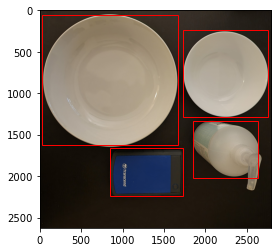

In [58]:
#plt.imshow(img_tensor.cpu().permute(1,2,0))
fig, ax = plt.subplots()
for i, sq in enumerate(keep):
    #if out[-1]["labels"][i] == 70:# and out[-1]["scores"][i] > 0.3:
    sq = sq.detach()
    rectangle = plt.Rectangle((sq[0], sq[1]), sq[2]-sq[0], sq[3]-sq[1], fill=False, color="red")
    ax.add_patch(rectangle)
plt.axis("scaled")
ax.imshow(img_tensor.cpu().permute(1,2,0))
#plt.ylim(250,0)
#plt.xlim(0,250)
plt.ylim(img.shape[1],0)
plt.xlim(0,img.shape[2])
#0,1,2,16

In [279]:
getting_relations_nms(keep)

({'object number:0': (206.0, 303.0),
  'object number:1': (713.0, 357.0),
  'object number:2': (520.0, 396.0),
  'object number:3': (463.0, 263.0),
  'object number:4': (636.0, 183.0),
  'object number:5': (300.0, 167.0)},
 {'0:0': 'left',
  '0:1': 'infront left',
  '0:2': 'infront left',
  '0:3': 'back left',
  '0:4': 'back left',
  '0:5': 'back left',
  '1:0': 'back right',
  '1:1': 'left',
  '1:2': 'front right',
  '1:3': 'back right',
  '1:4': 'back right',
  '1:5': 'back right',
  '2:0': 'back right',
  '2:1': 'back left',
  '2:2': 'left',
  '2:3': 'back right',
  '2:4': 'back left',
  '2:5': 'back right',
  '3:0': 'front right',
  '3:1': 'infront left',
  '3:2': 'infront left',
  '3:3': 'left',
  '3:4': 'back left',
  '3:5': 'back right',
  '4:0': 'front right',
  '4:1': 'infront left',
  '4:2': 'front right',
  '4:3': 'front right',
  '4:4': 'left',
  '4:5': 'back right',
  '5:0': 'front right',
  '5:1': 'infront left',
  '5:2': 'infront left',
  '5:3': 'infront left',
  '5:4': 